## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [6]:
data = pd.read_csv('data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [8]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
#  data.info()
data_daily = data.groupby(['date', 'group']).agg({
    'user_id': 'count',
    'purchase': 'sum',
    'price': 'sum'
}).reset_index().rename(columns={'purchase': 'purchase_count', 'price': 'purchase_amount', 'user_id': 'user_count'})
# data_daily.head()
display(data_daily[data_daily['date']==data_daily['date'].min()])
display(data_daily[data_daily['date']==data_daily['date'].max()])

,date,group,user_count,purchase_count,purchase_amount
0,2021-01-02,A,2894,362,29720000
1,2021-01-02,B,2889,348,29920000


,date,group,user_count,purchase_count,purchase_amount
44,2021-01-24,A,3811,451,33700000
45,2021-01-24,B,3727,449,39280000


## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [6]:
# посещения сайта
print('Количество посещений сайта группа А:', data_daily[data_daily['group'] == 'A']['user_count'].sum())
print('Количество посещений сайта группа B:', data_daily[data_daily['group'] == 'B']['user_count'].sum())

Количество посещений сайта группа А: 147202
Количество посещений сайта группа B: 147276


In [7]:
# количество покупок
print('Количество покупок в группе А:', data_daily[data_daily['group'] == 'A']['purchase_count'].sum())
print('Количество покупок в группе В:', data_daily[data_daily['group'] == 'B']['purchase_count'].sum())

Количество покупок в группе А: 17723
Количество покупок в группе В: 17514


In [9]:
# сумма покупок
print('Сумма покупок в группе А:', data_daily[data_daily['group'] == 'A']['purchase_amount'].sum()/1000000, 'млн. руб.')
print('Сумма покупок в группе В:', data_daily[data_daily['group'] == 'B']['purchase_amount'].sum()/1000000, 'млн. руб.')

Сумма покупок в группе А: 1436.26 млн. руб.
Сумма покупок в группе В: 1554.1 млн. руб.


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [9]:
# выборка группы А
a_data = data[data['group'] == 'A']
# выборка группы B
b_data = data[data['group'] == 'B']
# поиск дубликатов в выборках
user_duplicates = set(a_data['user_id']).intersection(set(b_data['user_id']))
print('Количество задвоенных пользователей:', len(user_duplicates))

Количество задвоенных пользователей: 1895


## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [10]:
updated_data = data[data['user_id'].apply(lambda x: x not in user_duplicates)]

Где user_duplicates - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

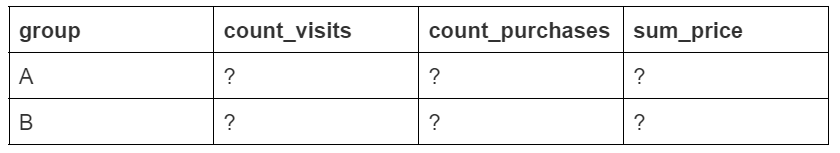
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [11]:
data_group = updated_data.groupby(['group']).agg({
    'user_id': 'count',
    'purchase': 'sum',
    'price': 'sum'
}).reset_index().rename(columns={'user_id': 'count_visits', 'purchase': 'count_purchases', 'price': 'sum_price'})
data_group

,group,count_visits,count_purchases,sum_price
0,A,145307,17487,1417780000
1,B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

**Выводы**

Сформированные выборки для тестирования в достаточной степени сбалансированы, т.к. количество транзакций (посещения сайта, количество покупок) по группам А и В приблизительно одинаковое, т.е. выборки достаточно равнозначны и их можно использовать для А/В тестирования.

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [12]:
# добавение столбца "конвресия"
data_group['conversion %'] = round((data_group['count_purchases']/data_group['count_visits']*100), 2)
# добавление столбца "средний чек"
data_group['mean_check'] = round(data_group['sum_price']/data_group['count_purchases'])
data_group

,group,count_visits,count_purchases,sum_price,conversion %,mean_check
0,A,145307,17487,1417780000,12.03,81076.0
1,B,145381,17290,1533010000,11.89,88665.0


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

**Выводы.**

Конверсия в группе А ненамного превышает конверсию в группе В (на 1,2%), тогда как средний чек в группе B на 8,9% выше, в связи с чем, можно сделать первичное предположение, что для увеличения количества продаж предпочтительнее первый вариант (А) посадочной страницы сайта, а для увеличения выручки (суммы продаж) – предпочтительнее второй вариант (B).

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [13]:
pivot_data = pd.pivot_table(updated_data, index = 'group', columns='price', values='purchase', aggfunc='sum')
pivot_data

price,0,10000,60000,100000,150000,200000
group,,,,,,
A,0,5182,5271,1832,3478,1724
B,0,5201,1730,5227,3438,1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

In [77]:
fig = px.imshow(
    pivot_data,
    text_auto=True,
    labels=dict(color='purshases_counts'),
    color_continuous_scale='plasma',
    title='Зависимость количества покупок от цены тура'
)
fig.show()

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

**Выводы.**

По турам ценовых категорий (10 тыс. руб., 150 тыс. руб., 200 тыс. руб.) покупательская способность практически одинаковая в обеих группах. В группе А покупательская способность выше по турам стоимостью 60 тыс. руб., а в группе В по турам стоимостью – 100 тыс. руб.

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [14]:
# группировка данных по дате и группе тестирования
data_daily = updated_data.groupby(['date', 'group']).agg({
    'user_id': 'count',
    'purchase': 'sum',
    'price': 'sum'
}).reset_index().rename(columns={'purchase': 'purchases_count', 'price': 'purchases_amount', 'user_id': 'visits_count'})
# добавление ежедневной конверсии
data_daily['conversion %'] = round((data_daily['purchases_count']/data_daily['visits_count']*100),2)
# добавление ежедневного среднего чека
data_daily['mean_check'] = round(data_daily['purchases_amount']/data_daily['purchases_count'])
data_daily.head()

,date,group,visits_count,purchases_count,purchases_amount,conversion %,mean_check
0,2021-01-02,A,2854,359,29410000,12.58,81922.0
1,2021-01-02,B,2861,345,29660000,12.06,85971.0
2,2021-01-03,A,6596,748,62000000,11.34,82888.0
3,2021-01-03,B,6619,754,65960000,11.39,87480.0
4,2021-01-04,A,6566,799,64250000,12.17,80413.0


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [15]:
# кумулятивное количество посещений страницы
data_daily['cum_visits_count'] = data_daily.groupby(['group'])['visits_count'].cumsum()
# кумулятивное количество покупок
data_daily['cum_purchases_count'] = data_daily.groupby(['group'])['purchases_count'].cumsum()
# кумулятивную сумму покупок
data_daily['cum_purchases_amount'] = data_daily.groupby(['group'])['purchases_amount'].cumsum()
# кумлятивная конверсия
data_daily['cum_conversion %'] = round((data_daily['cum_purchases_count']/data_daily['cum_visits_count']*100),2)
# кумулятивный средний чек
data_daily['cum_mean_check'] = round(data_daily['cum_purchases_amount']/data_daily['cum_purchases_count'])
#data_daily.head()
data_daily.loc[data_daily['date'] == '2021-01-20']
#data_daily.loc[data_daily['date'] == '2021-01-12']

,date,group,visits_count,purchases_count,purchases_amount,conversion %,mean_check,cum_visits_count,cum_purchases_count,cum_purchases_amount,cum_conversion %,cum_mean_check
36,2021-01-20,A,6533,749,58710000,11.46,78385.0,121506,14561,1179590000,11.98,81010.0
37,2021-01-20,B,6685,790,69250000,11.82,87658.0,121857,14496,1286900000,11.90,88776.0


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

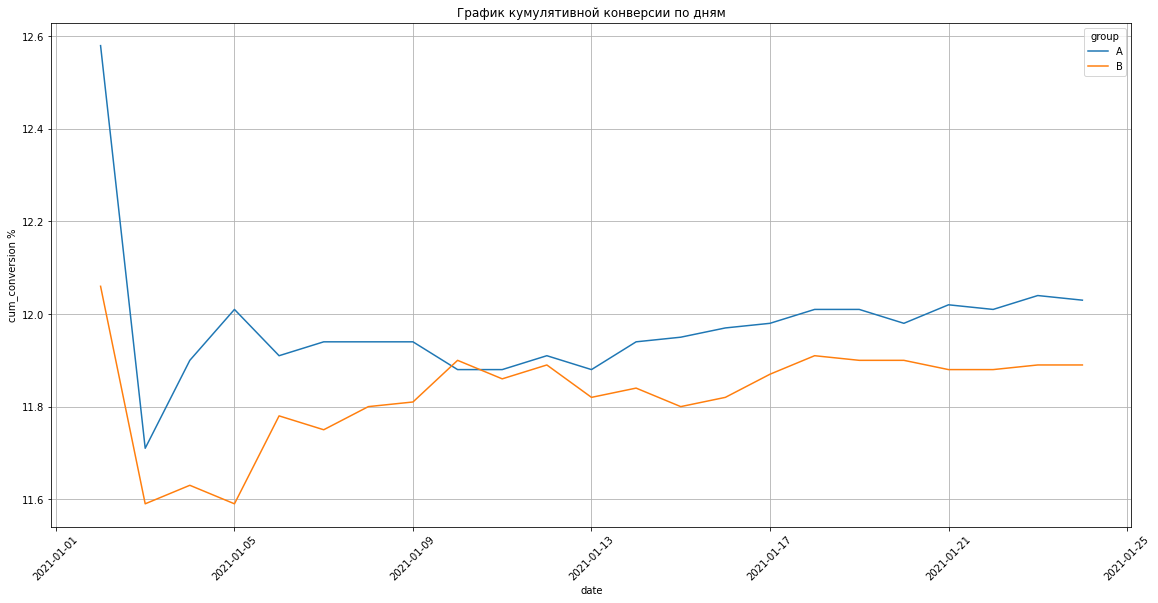

In [16]:
# график кумулятивной конверсии 
fig = plt.figure(figsize=(15,7))
ax=fig.add_axes([1, 1, 1, 1])
sns.lineplot(x='date', y='cum_conversion %', data=data_daily, hue='group', ax=ax)
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True)

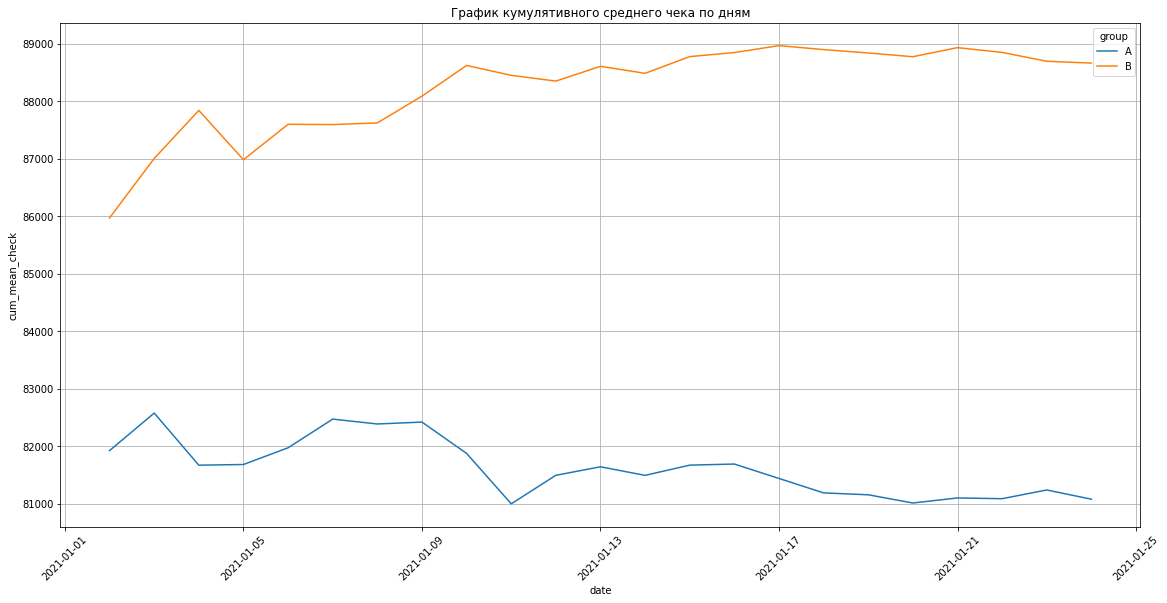

In [17]:
# график кумулятивного среднего чека 
fig = plt.figure(figsize=(15,7))
ax=fig.add_axes([1, 1, 1, 1])
sns.lineplot(x='date', y='cum_mean_check', data=data_daily, hue='group', ax=ax)
ax.set_title('График кумулятивного среднего чека по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True)

**Выводы.**

До 2021-01-10 конверсия была нестабильна, но после 2021-01-10 резкие скачки прекратились, предположительно с завершением новогодних каникул спонтанные покупки прекратились. Судя по графику, конверсия группы B стабильно немного хуже конверсии группы А практически на всём промежутке времени. 

До 2021-01-11 средний чек был нестабильным, но после 2021-01-11 резкие скачки прекратились. Судя по графику, средний чек группы B стабильно больше среднего чека группы А на всём промежутке времени. 

На основании стабилизированных кумулятивных графиков можно сделать вывод, что длительность эксперимента была достаточной для того, чтобы судить о статистической значимости разности между показателем конверсии и среднего чека в группах.

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [18]:
# используем сводную таблицу из задания 7.5
data_group = updated_data.groupby(['group']).agg({
    'user_id': 'count',
    'purchase': 'sum',
    'price': 'sum'
}).reset_index().rename(columns={'user_id': 'count_visits', 'purchase': 'count_purchases', 'price': 'sum_price'})
data_group

,group,count_visits,count_purchases,sum_price
0,A,145307,17487,1417780000
1,B,145381,17290,1533010000


In [19]:
# т.к. конверсия - это пропорция, используем z-тест
from statsmodels.stats.proportion import proportions_ztest
# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А больше чем конверсия в группе B'
# уровень значимости
alpha = 0.05 
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=data_group['count_purchases'], #число "успехов"
    nobs=data_group['count_visits'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  0.12
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

**Выводы.**

Т.к. конверсия – это относительная величина (пропорция), для проверки статистической значимости разницы между метриками в группах А и В использовали Z-тест. 

Гипотеза о статистическом равенстве конверсий в группах А и B верна с уровнем значимости 0,05, соответственно, вид посадочной старицы сайта в вариантах А и В не влияет на конверсию, что дополнительно подтверждается графиком кумулятивной конверсии (задание 7.9).

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [20]:
# данные по группам тестирования без задвоений
updated_data_a = updated_data[updated_data['group'] == 'A']
updated_data_b = updated_data[updated_data['group'] == 'B']

from scipy.stats import norm
# функция определения доверительного интервала для истинной пропорции
def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

# размер выборок
n_a = updated_data_a['user_id'].count()
n_b = updated_data_b['user_id'].count()

# выборочная пропорция
x_p_a = updated_data_a['purchase'].mean()
x_p_b = updated_data_b['purchase'].mean()

print('Доверительный интервал для конверсии группы А: {}'.format(proportions_conf_interval(n_a, x_p_a)))
print('Доверительный интервал для конверсии группы В: {}'.format(proportions_conf_interval(n_b, x_p_b)))

# функция доверительного интервала разницы пропорций
def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

print('Доверительный интервал для разности конверсий: {}'.format(diff_proportions_conf_interval([n_a, n_b], [x_p_a, x_p_b]))) 

Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы В: (11.73, 12.06)
Доверительный интервал для разности конверсий: (-0.38, 0.09)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

**Выводы.**

В соответствии с полученными результатами, можно сделать вывод, что с надёжностью в 95 % конверсия группы А лежит в интервале от 11.87 % до 12.2 %, а конверсия группы B лежит в интервале от 11.73 % до 12.06 %. 

Построенный доверительный интервал с 95 %-ой надёжностью свидетельствует о том, что разница в конверсии между вариантом B и вариантом А лежит в интервале от -0.38 % до 0.09 %.

Соответственно, статистической разницы в конверсии между вариантами А и B нет, то есть они являются равнозначными по данной метрике.


## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [21]:
# ежедневные данные по группам тестирования
data_daily_a = data_daily[data_daily['group'] == 'A']
data_daily_b = data_daily[data_daily['group'] == 'B']

# для проверки нормальности распределения используем тесте Шапиро-Уилка
from scipy.stats import shapiro

# гипотезы 
H0 = 'Распределения в группах А и В нормальные'
H1 = 'Распределения в группе А, В или обеих отличны от нормального (отвергаем H0)'
# уровень значимости
alpha = 0.05

shapiro_result_a = shapiro(data_daily_a['mean_check'])
print('p-value группы A', round(shapiro_result_a.pvalue, 2))
shapiro_result_b = shapiro(data_daily_b['mean_check'])
print('p-value группы B', round(shapiro_result_b.pvalue, 2))

# сравнение вычисленного p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
	print("Принимаем нулевую гипотезу. {}".format(H0))

p-value группы A 0.25
p-value группы B 0.09
Принимаем нулевую гипотезу. Распределения в группах А и В нормальные


## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [23]:
# гипотезы
H0 = 'Ежедневные средние чеки в группах А и B равны'
H1 = 'Ежедневный средний чек в группе А меньше чем в группе B'
alpha = 0.05 #уровень значимости

from scipy.stats import ttest_ind
#T-тест для сравнения средних значений в выборках
results = ttest_ind(
    data_daily_a['mean_check'],
    data_daily_b['mean_check'],
    alternative='less'
)
print('p-value:', round(results.pvalue, 3))
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value: 0.0
Отвергаем нулевую гипотезу. Ежедневные средние чеки в группах А и B равны
Альтернативная гипотеза. H1: Ежедневный средний чек в группе А меньше чем в группе B


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

**Выводы.**

Для сравнения значений средних ежедневных чеков в группах А и В (средних значений выборок) применили Т-тест. В соответствии с результатами проведенного теста ежедневный средний чек в группе А ниже, чем в группе B. 

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [28]:
from scipy.stats import t

# функция доверительного интервала для истинного среднего
def mean_check_conf_interval(n, x_mean, x_std, gamma=0.95):
    k = n - 1 #число степеней свободы
    alpha = 1 - gamma # уровень значимости
    t_crit = -t.ppf(alpha/2, k) # t критическое
    eps = t_crit * x_std / n**0.5 #погрешность
    lower_bound = x_mean - eps # левая (нижняя) граница
    upper_bound = x_mean + eps # правая (верхняя) граница
    # возвращаем кортеж из округленных границ интервала
    return round(lower_bound), round(upper_bound)

# размер выборок
n_a = data_daily_a['visits_count'].count()
n_b = data_daily_b['visits_count'].count()
# выборочные средние
x_mean_a = data_daily_a['mean_check'].mean()
x_mean_b = data_daily_b['mean_check'].mean()
# выборочные средние отклонения
x_std_a = data_daily_a['mean_check'].std()
x_std_b = data_daily_b['mean_check'].std()

print('Доверительный интервал для среднего чека группы А: {}'.format(mean_check_conf_interval(n_a, x_mean_a, x_std_a))) 
print('Доверительный интервал для среднего чека группы B: {}'.format(mean_check_conf_interval(n_b, x_mean_b, x_std_b)))

Доверительный интервал для среднего чека группы А: (79630, 82308)
Доверительный интервал для среднего чека группы B: (87626, 89526)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

**Выводы.**

С вероятностью 95 %, что средний чек при первом варианте посадочной страницы (группа А) лежит в интервале от 79 630 до 82 308 рублей, при втором варианте (группа В) в интервале от 87 626 до 89 526 рублей. Интервалы не пересекаются.

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

В соответствии с данными проведенного тестирования с 95% надежностью можно утверждать, что дизайн посадочной страницы не влияет на конверсию, но влияет на среднюю сумму покупки, т.к. по данным статистического исследования доверительный интервал распределения среднего чека при выварите А посадочной страницы сайта составляет от 79 630 до 82 308 рублей, тогда как для варианта В – от 87. 626 до 89 526 рублей. Соответственно, вариант В посадочной страницы сайта является предпочтительным по совокупности метрик.